In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras

from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, generate_testing_mixup_images, find_boundary_points
from plotting_functions import plot_3_confusion_matricies, plot_calibration, muba_curves
import pandas as pd


In [2]:
data_flag = 'vesselmnist3d'

download = True

image_size = 28

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [3]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\vesselmnist3d.npz


In [4]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=2, image_size = image_size, three_d=True)


In [5]:
# As a sanity check to make sure we have the correct test data, check counts

get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names =['vessel', 'aneurysm'])


Train
{(0, 1): 150, (1, 0): 1185}  ['vessel', 'aneurysm']

Val
{(0, 1): 22, (1, 0): 169}  ['vessel', 'aneurysm']

Test A
{(0, 1): 13, (1, 0): 101}  ['vessel', 'aneurysm']

Test B
{(0, 1): 30, (1, 0): 238}  ['vessel', 'aneurysm']


In [6]:
test_set_A_df = pd.DataFrame({
    "image_index":[i for i in range(len(y_test_A))],
    "class":[label[1] for label in y_test_A]}) # 0 if vessel, 1 if aneurysm

In [7]:
MUBA_ITERS = 20

muba_df = generate_testing_mixup_images(test_set_A_df, X_test_A, MUBA_ITERS)

In [8]:
# To allow for reproducability, we add our alpha values
alpha_values = muba_df["alpha_class_0"]
alpha_values.to_csv("alpha_values.csv")

In [9]:
model = keras.models.load_model("best_model_epoch_09.h5")
activations_model = keras.Model(model.input,model.layers[-2].output)

In [10]:
predictions_A = model.predict(X_test_A)
activations_A = activations_model.predict(X_test_A)

predictions_B = model.predict(X_test_B)
activations_B = activations_model.predict(X_test_B)

print("Stacking - this can take some time.")
stacked_images = np.stack(muba_df["image"])
predictions_mixup = model.predict(stacked_images)
activations_mixup = activations_model.predict(stacked_images)

9/9 [==============================] - 0s 9ms/step
Stacking - this can take some time.
821/821 [==============================] - 8s 10ms/step


In [11]:
muba_df["predictions_0"] = [p[0] for p in predictions_mixup]
muba_df["predictions_1"] = [p[1] for p in predictions_mixup]
muba_df["argmax_pred"] = [np.argmax(p) for p in predictions_mixup]
muba_df["activations"] = [a for a in activations_mixup]

In [12]:
muba_df.head(1)

,alpha_class_0,alpha_class_1,class_0_index,class_1_index,image,type,label,predictions_0,predictions_1,argmax_pred,activations
0,0.003432,0.996568,0,9,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",mix,1,0.281312,0.718688,1,"[0.0, 0.599991, 0.0, 0.0, 1.0555886, 0.2980305..."


In [13]:
boundary_points_df = find_boundary_points(muba_df, X_test_A, MUBA_ITERS)

In [14]:
predictions_boundary = model.predict(np.stack(boundary_points_df["image"]))
activations_boundary = activations_model.predict(np.stack(boundary_points_df["image"]))

24/24 [==============================] - 0s 10ms/step


In [15]:
test_set_A_df = pd.DataFrame({
    "alpha_class_0" : [label[0] for label in y_test_A],
    "alpha_class_1" : [label[1] for label in y_test_A],
    "class_0_index" : None,
    "class_1_index" : None,
    "image" : [image for image in X_test_A],
    "type" : "A",
    "label" : [np.argmax(l) for l in y_test_A],
    "predictions_0" : [p[0] for p in predictions_A],
    "predictions_1" : [p[1] for p in predictions_A],
    "argmax_pred" : [np.argmax(p) for p in predictions_A],
    "activations" : [a for a in activations_A]
})
test_set_B_df = pd.DataFrame({
    "alpha_class_0" : [label[0] for label in y_test_B],
    "alpha_class_1" : [label[1] for label in y_test_B],
    "class_0_index" : None,
    "class_1_index" : None,
    "image" : [image for image in X_test_B],
    "type" : "B",
    "label" : [np.argmax(l) for l in y_test_B],
    "predictions_0" : [p[0] for p in predictions_B],
    "predictions_1" : [p[1] for p in predictions_B],
    "argmax_pred" : [np.argmax(p) for p in predictions_B],
    "activations" : [a for a in activations_B]
})

boundary_points_df["predictions_0"] = [p[0] for p in predictions_boundary]
boundary_points_df["predictions_1"] = [p[1] for p in predictions_boundary]
boundary_points_df["argmax_pred"] = [np.argmax(p) for p in predictions_boundary]
boundary_points_df["activations"] = [a for a in activations_boundary]

In [16]:
df = pd.concat([test_set_A_df, test_set_B_df, muba_df, boundary_points_df],axis=0, ignore_index=True)

In [17]:
muba_projections = TSNE(2,random_state=1).fit_transform(np.stack(df["activations"]))

In [18]:
df["projection_x"] = [x[0] for x in muba_projections]
df["projection_y"] = [x[1] for x in muba_projections]

In [19]:
df_to_save = df.drop(columns=["image"])
df_to_save.to_pickle("muba_df.csv")

In [2]:
df = pd.read_pickle("muba_df.csv")

In [3]:
true_images_A_df = df[df["type"] == "A"]
true_images_B_df = df[df["type"] == "B"]

mixup_images_df =  df[df["type"] == "mix"]
boundary_images_df = df[df["type"] == "boundary"]

true_A_class_0 = true_images_A_df[true_images_A_df["label"] == 0]
true_A_class_1 = true_images_A_df[true_images_A_df["label"] == 1]

true_B_class_0 = true_images_B_df[true_images_B_df["label"] == 0]
true_B_class_1 = true_images_B_df[true_images_B_df["label"] == 1]

mixup_0 = mixup_images_df[mixup_images_df["label"] == 0]
mixup_1 = mixup_images_df[mixup_images_df["label"] == 1]

true_A_errors = true_images_A_df[true_images_A_df["label"] != true_images_A_df["argmax_pred"]]
true_B_errors = true_images_B_df[true_images_B_df["label"] != true_images_B_df["argmax_pred"]]
mixup_errors = mixup_images_df[mixup_images_df["label"] != mixup_images_df["argmax_pred"]]

error_free_true_A_class_0 = true_A_class_0[true_A_class_0["label"] == true_A_class_0["argmax_pred"]]
error_free_true_A_class_1 = true_A_class_1[true_A_class_1["label"] == true_A_class_1["argmax_pred"]]
error_free_mixup_class_0 = mixup_0[mixup_0["label"] == mixup_0["argmax_pred"]]
error_free_mixup_class_1 = mixup_1[mixup_1["label"] == mixup_1["argmax_pred"]]

In [4]:
print(classification_report(mixup_images_df["label"],mixup_images_df["argmax_pred"]))

              precision    recall  f1-score   support

           0       0.61      0.92      0.73     13130
           1       0.83      0.41      0.54     13130

    accuracy                           0.66     26260
   macro avg       0.72      0.66      0.64     26260
weighted avg       0.72      0.66      0.64     26260



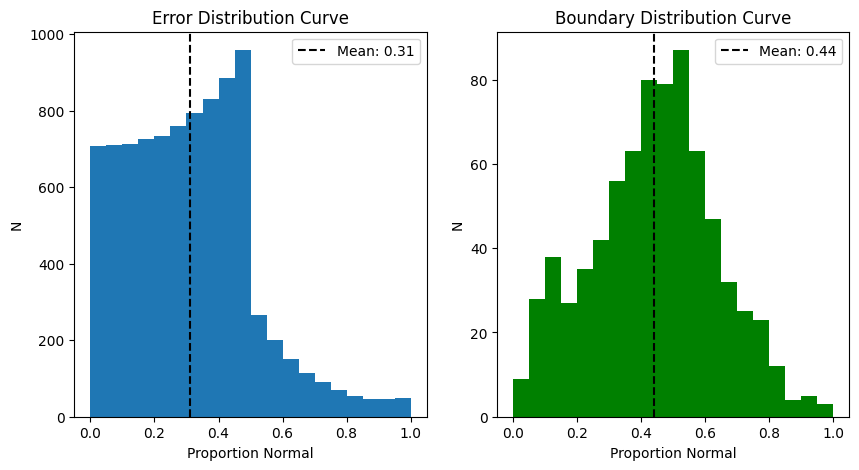

In [5]:
muba_curves(mixup_errors,boundary_images_df, xlabel= "Proportion Normal")

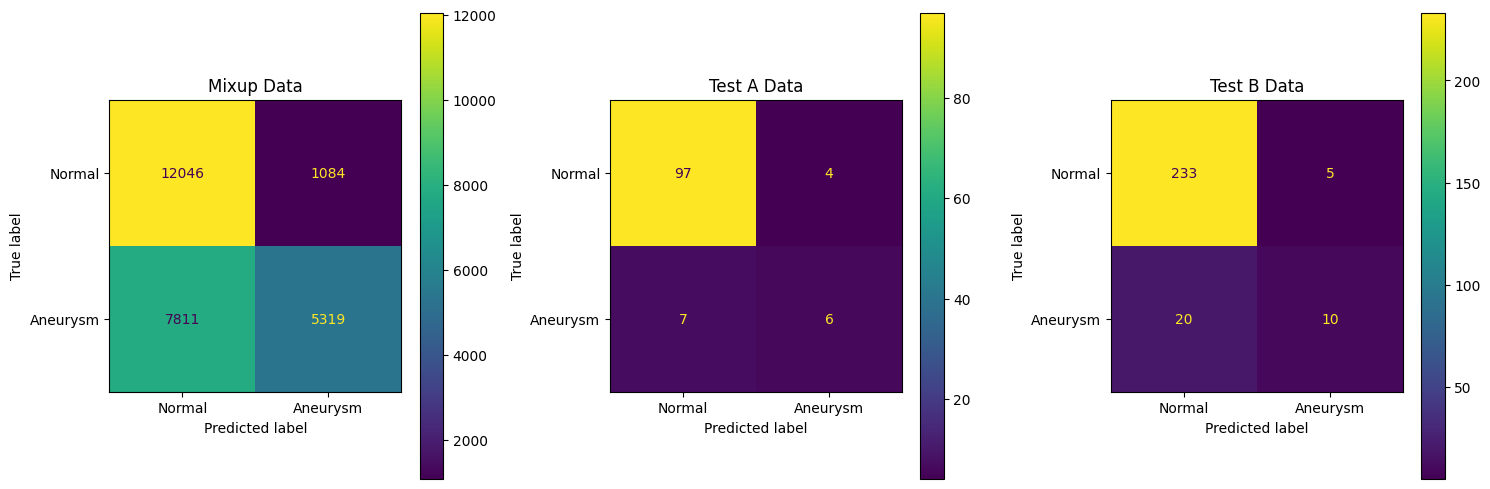

In [6]:
plot_3_confusion_matricies(mixup_images_df,true_images_A_df,true_images_B_df, labels = ["Normal", "Aneurysm"])

In [7]:
import matplotlib.colors as mcolors

def plot_projections(colour_by_alpha: bool = True,
                     include_errors: bool = True,
                     outline_errors: bool = True,
                     show_boundary_points: bool = True,
                     scale_errors: bool = False,
                     colour_boundaries_by_alpha: bool = False,
                     include_type_B: bool = False
                     ):
    
    a=None
    fig, ax = plt.subplots(figsize=(14, 10))

    # Combine two colour maps
    colors1 = plt.cm.Reds_r(np.linspace(0., 1, 128))
    colors2 = plt.cm.Blues(np.linspace(0, 1, 128))

    # Build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    # Plot mixup points
    if colour_by_alpha:
        ax.scatter(error_free_mixup_class_A["projection_x"],error_free_mixup_class_A["projection_y"],marker="o",s=1,c = error_free_mixup_class_A["alpha_class_0"],cmap = "Reds",vmin=0.5,vmax=1)
        ax.scatter(error_free_mixup_class_B["projection_x"],error_free_mixup_class_B["projection_y"],marker="o",s=1,c = error_free_mixup_class_B["alpha_class_0"],cmap = "Blues_r", label = "Mix-up",vmin=0,vmax=0.5)

    # Plot mixup errors
    if include_errors:

        if colour_by_alpha:
            ax.scatter(mixup_errors["projection_x"],mixup_errors["projection_y"],marker="o",s = (mixup_errors["min_alpha"]*7)**4 if scale_errors else 20 ,c = mixup_errors["alpha_class_0"],cmap = mymap, edgecolors="black",label="Mix-up Incorrect Prediction",vmin=0,vmax=1)
        elif not colour_by_alpha:
            ax.scatter(mixup_class_0["projection_x"],mixup_class_0["projection_y"],marker="o",s=20,color = "salmon",label="Mix-up Class Demented")
            ax.scatter(mixup_class_1["projection_x"],mixup_class_1["projection_y"],marker="o",s=20,color = "deepskyblue",label="Mix-up Class Non-Demented")
            ax.scatter(mixup_errors["projection_x"],mixup_errors["projection_y"],marker="o",s=20,color="None",edgecolors = "black" if outline_errors else None,label="Mix-up Incorrect Prediction")
    
    elif not include_errors:
        if not colour_by_alpha:
            ax.scatter(error_free_mixup_class_A["projection_x"],error_free_mixup_class_A["projection_y"],marker="o",s=10,color = "salmon",label="Mix-up Class Demented")
            ax.scatter(error_free_mixup_class_B["projection_x"],error_free_mixup_class_B["projection_y"],marker="o",s=10,color = "deepskyblue",label="Mix-up Class Non Demented")

    # Plot normal points
    ax.scatter(true_A_class_0["projection_x"],true_A_class_0["projection_y"],marker="^",s=50,color="red",label="True Class Demented")
    ax.scatter(true_A_class_1["projection_x"],true_A_class_1["projection_y"],marker="^",s=50,color="blue",label="True Class Non Demented")
    ax.scatter(true_A_errors["projection_x"],true_A_errors["projection_y"],marker="^",s=50,color="None",edgecolors = "black",label="Incorrect Prediction",)

    if show_boundary_points:
        ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"],marker="o",s=20,c="green" if not colour_boundaries_by_alpha else boundary_images_df["alpha_class_0"],cmap = mymap if colour_boundaries_by_alpha else None, vmin = 0, vmax = 1 ,label="Boundary Points", edgecolors = "black" if colour_boundaries_by_alpha else None)
    
    if include_type_B:
        ax.scatter(true_B_class_0["projection_x"],true_B_class_0["projection_y"],marker="^",s=50,color="yellow",label="True Class Demented - Test Set B")
        ax.scatter(true_B_class_1["projection_x"],true_B_class_1["projection_y"],marker="^",s=50,color="purple",label="True Class Non Demented - Test Set B")
        ax.scatter(true_B_errors["projection_x"],true_B_errors["projection_y"],marker="^",s=50,color="None",edgecolors = "black",label="Incorrect Prediction",)

    ax.legend()

    ax.set_title("t-SNE Dimension Analysis")

    if colour_by_alpha or colour_boundaries_by_alpha or include_errors:
        a = ax.scatter([0,1],[0,1],s=0,vmin=0,vmax=1,c=[0,1],cmap=mymap)
        plt.colorbar(a,label = "Class Demented Alpha Value")
    

    plt.show()

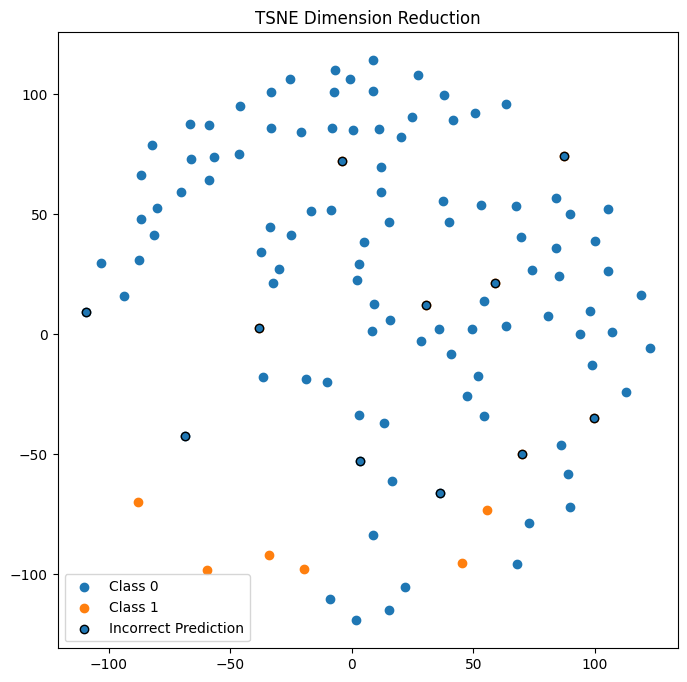

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

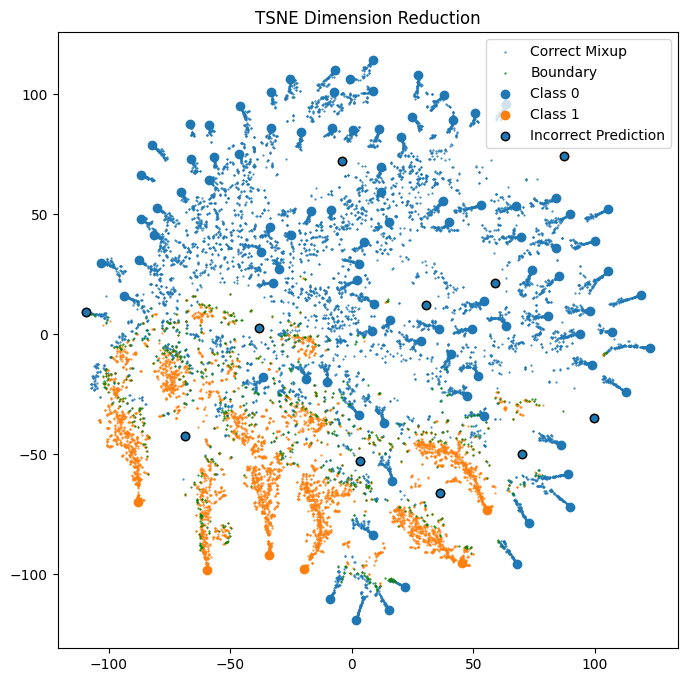

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(error_free_mixup_class_0["projection_x"],error_free_mixup_class_0["projection_y"], color = "C0", marker = ".", s = 1, label = "Correct Mixup")
ax.scatter(error_free_mixup_class_1["projection_x"],error_free_mixup_class_1["projection_y"], color = "C1", marker = ".", s = 1)
ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], color = "green", marker = ".", s = 1, label = "Boundary")

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

In [10]:
multiple_boundaries_mask = boundary_images_df.duplicated(subset=["class_0_index","class_1_index"], keep=False)
multiple_boundaries = boundary_images_df[multiple_boundaries_mask]

In [11]:
multiple_boundaries

,alpha_class_0,alpha_class_1,class_0_index,class_1_index,type,label,predictions_0,predictions_1,argmax_pred,activations,projection_x,projection_y
26650,0.054676,0.945324,1,63,boundary,1,0.499792,0.500207,1,"[0.0, 0.8624018, 0.0, 0.053612214, 1.0671616, ...",-47.528610,5.773348
26651,0.260957,0.739043,1,63,boundary,1,0.593921,0.406079,0,"[0.0, 0.7881684, 0.0, 0.06913614, 1.2439104, 0...",-32.755253,7.481903
26693,0.392728,0.607272,8,16,boundary,1,0.504714,0.495286,0,"[0.0, 0.69008833, 0.0, 0.0, 0.7430861, 0.03089...",16.521784,-46.768055
26694,0.559734,0.440266,8,16,boundary,0,0.511734,0.488266,0,"[0.0, 0.7510525, 0.0, 0.0, 0.9868468, 0.296313...",15.824132,-47.828056
26737,0.516270,0.483730,17,18,boundary,0,0.500410,0.499590,0,"[0.0, 0.87037534, 0.0, 0.12662163, 0.5935978, ...",1.153020,-3.908940
...,...,...,...,...,...,...,...,...,...,...,...,...
27390,0.599956,0.400044,112,16,boundary,0,0.474081,0.525919,1,"[0.0, 0.6960774, 0.0, 0.0, 0.0, 0.0, 0.1942635...",75.716599,-57.805061
27392,0.096710,0.903290,112,63,boundary,1,0.499200,0.500800,1,"[0.14849792, 0.881014, 0.0, 0.0, 1.0173414, 0....",-57.599663,11.151222
27393,0.394991,0.605009,112,63,boundary,1,0.487933,0.512067,1,"[7.353583e-05, 0.526854, 0.0, 0.0, 0.9121341, ...",-32.998882,-28.352940
27397,0.345629,0.654371,112,88,boundary,1,0.510632,0.489368,0,"[0.033832304, 0.658533, 0.0, 0.0, 1.0223589, 0...",-37.050716,-11.681796


In [12]:
POINT_0 = 92 # (99,2)
POINT_1 = 75

POINT_0_df = true_A_class_0.loc[[POINT_0]]
POINT_1_df = true_A_class_1.loc[[POINT_1]]

point_1_df = mixup_images_df[mixup_images_df["class_0_index"]==POINT_0]
path_df = point_1_df[point_1_df["class_1_index"]==POINT_1]

boundary_points_1 = boundary_images_df[boundary_images_df["class_0_index"]==POINT_0]
boundary_point = boundary_points_1[boundary_points_1["class_1_index"]==POINT_1]
print(len(boundary_point))
if len(POINT_0_df) == 0:
    print(f"Point {POINT_0} is not in this class")
if len(POINT_1_df) == 0:
    print(f"Point {POINT_1} is not in this class")

path_df = pd.concat([POINT_0_df, POINT_1_df, boundary_point, path_df],axis=0,ignore_index=False).sort_values("alpha_class_0")


1


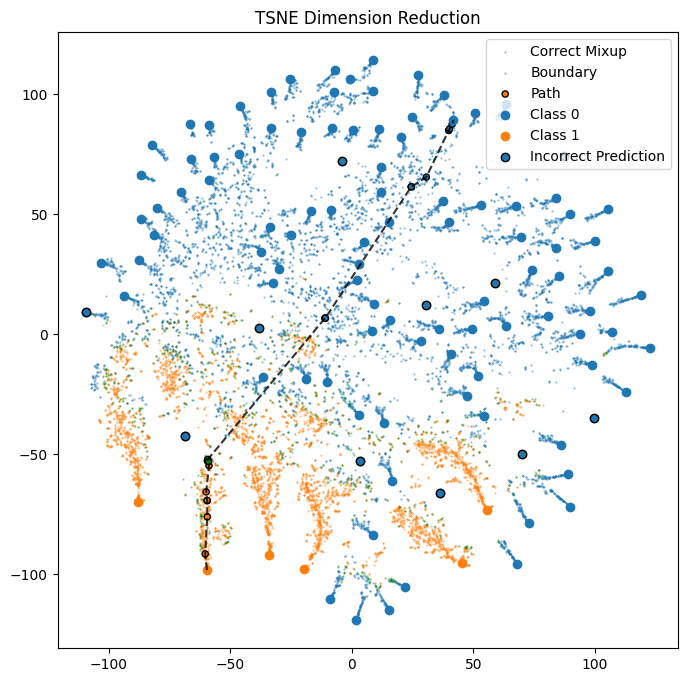

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(error_free_mixup_class_0["projection_x"],error_free_mixup_class_0["projection_y"], color = "C0", alpha= 0.5, marker = ".", s = 1, label = "Correct Mixup")
ax.scatter(error_free_mixup_class_1["projection_x"],error_free_mixup_class_1["projection_y"], color = "C1", alpha= 0.5, marker = ".", s = 1)
ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], color = "green", alpha= 0.5, marker = ".", s = 1, label = "Boundary")

ax.plot(path_df["projection_x"],path_df["projection_y"],alpha=0.8,linestyle="--",color="black")

ax.scatter(path_df["projection_x"],path_df["projection_y"],marker="o",s=20,c=["C0" if l == 0 else "C1" for l in path_df["argmax_pred"]], edgecolors = "black",label="Path")
ax.scatter(boundary_point["projection_x"],boundary_point["projection_y"],marker="o",s=20,c="green", edgecolors = "black")

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

In [14]:
from scipy import spatial
from collections import Counter

# This may be a function that we want to change for different models, so we define it within the notebook.
def get_distances():

    all_images_without_B_df = df[df["type"] != "B"].reset_index()
    activations_A = [a for a in true_images_A_df["activations"]]
    activations_B = [a for a in true_images_B_df["activations"]]
    activations_mixup = [a for a in mixup_images_df["activations"]]
    activations_boundary = [a for a in boundary_images_df["activations"]]
    all = [a for a in all_images_without_B_df["activations"]]

    tree_true_A = spatial.KDTree(activations_A)
    tree_true_B = spatial.KDTree(activations_B)
    tree_mixup  = spatial.KDTree(activations_mixup)
    tree_boundaries = spatial.KDTree(activations_boundary)
    tree_all = spatial.KDTree(all)

    distances_to_all = []
    distances_B_to_boundary = []
    distances_B_to_mixup = []
    B_class_0_to_boundary = []
    B_class_1_to_boundary = []
    B_class_0_correct_to_boundary = []
    B_class_1_correct_to_boundary = []
    B_class_0_incorrect_to_boundary = []
    B_class_1_incorrect_to_boundary = []
    types = []
    distance_B_to_B = []
    
    distances_A_to_boundary = []
    A_class_0_to_boundary = []
    A_class_1_to_boundary = []
    A_class_0_incorrect_to_boundary = []
    A_class_1_incorrect_to_boundary = []
    distance_A_to_A = []

    for vector, label, pred in zip(activations_B,true_images_B_df["label"],true_images_B_df["argmax_pred"]):

        distance, id = tree_all.query(vector)
        types.append(all_images_without_B_df.loc[[id]]["type"][id])
        distances_to_all.append(distance)

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_B_to_B.append(tree_true_B.query(vector,2)[0][1])
        distances_B_to_boundary.append(boundary_dist)
        distances_B_to_mixup.append(tree_mixup.query(vector)[0])

        if label == 0:
            B_class_0_to_boundary.append(boundary_dist)
            if pred == 1:#Incorrect
                B_class_0_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_0_correct_to_boundary.append(boundary_dist)
        else:
            B_class_1_to_boundary.append(boundary_dist)
            if pred == 0:#Incorrect
                B_class_1_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_1_correct_to_boundary.append(boundary_dist)


    for vector, label, pred in zip(activations_A, true_images_A_df["label"],true_images_A_df["argmax_pred"]):

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_A_to_A.append(tree_true_A.query(vector,2)[0][1])
        distances_A_to_boundary.append(boundary_dist)

        if label == 0:
            A_class_0_to_boundary.append(boundary_dist)
            if pred == 1: #Incorrect
                A_class_0_incorrect_to_boundary.append(boundary_dist)
        else:
            A_class_1_to_boundary.append(boundary_dist)
            if pred == 0:#Incorrect
                A_class_1_incorrect_to_boundary.append(boundary_dist)

    counts = Counter(types)

    print("Average Distance between Set B Images and all other images: ", np.mean(distances_to_all))
    print("Counts: ",counts)
    print("Average shortest distance from Set B Images to Boundary: ",np.mean(distances_B_to_boundary))
    print("Average shortest distance from Set B Images to Mixup Point: ",np.mean(distances_B_to_mixup))
    print("Average shortest distance from Set B Images to B Images: ",np.mean(distance_B_to_B))

    print("Average shortest distance from Test Set B Class 0 to Boundary: ",np.mean(B_class_0_to_boundary))
    print("Average shortest distance from Test Set B Class 1 to Boundary: ",np.mean(B_class_1_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 0 to Boundary: ",np.mean(B_class_0_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 1 to Boundary: ",np.mean(B_class_1_incorrect_to_boundary))
   
    print("\nAverage shortest distance from Set A Images to Boundary: ",np.mean(distances_A_to_boundary))
    print("Average shortest distance from Set A Images to A Images: ",np.mean(distance_A_to_A))
    print("Average shortest distance from Test Set A Class 0 to Boundary: ",np.mean(A_class_0_to_boundary))
    print("Average shortest distance from Test Set A Class 1 to Boundary: ",np.mean(A_class_1_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 0 to Boundary: ",np.mean(A_class_0_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 1 to Boundary: ",np.mean(A_class_1_incorrect_to_boundary))
   
    return distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary

In [15]:
distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary = get_distances()


Average Distance between Set B Images and all other images:  1.5973760228501568
Counts:  Counter({'mix': 244, 'A': 22, 'boundary': 2})
Average shortest distance from Set B Images to Boundary:  3.6025468167008086
Average shortest distance from Set B Images to Mixup Point:  1.598175825261185
Average shortest distance from Set B Images to B Images:  1.839151599000047
Average shortest distance from Test Set B Class 0 to Boundary:  3.773373101727361
Average shortest distance from Test Set B Class 1 to Boundary:  2.2473249554901584
Average shortest distance from Test Set B Incorrect Class 0 to Boundary:  1.9304165034687686
Average shortest distance from Test Set B Incorrect Class 1 to Boundary:  2.324972872500831

Average shortest distance from Set A Images to Boundary:  3.5265653763101112
Average shortest distance from Set A Images to A Images:  1.999904282483316
Average shortest distance from Test Set A Class 0 to Boundary:  3.758328016211403
Average shortest distance from Test Set A Class

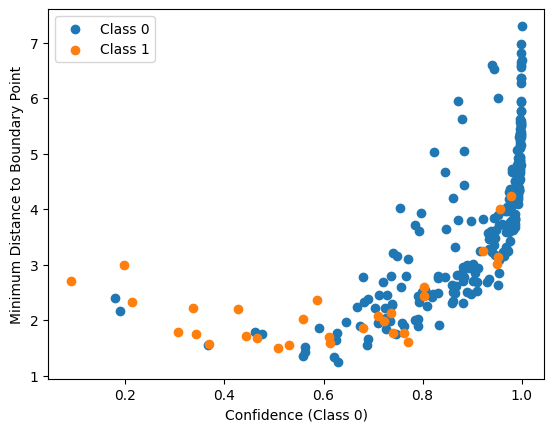

In [16]:
plt.scatter(true_images_B_df[true_images_B_df["label"]==0]["predictions_0"],B_class_0_to_boundary, label = "Class 0")
plt.scatter(true_images_B_df[true_images_B_df["label"]==1]["predictions_0"],B_class_1_to_boundary, label = "Class 1")
plt.xlabel("Confidence (Class 0)")
plt.ylabel("Minimum Distance to Boundary Point")
plt.legend()

In [17]:
from scipy.stats import pearsonr

print(pearsonr(true_images_B_df[true_images_B_df["label"]==0]["predictions_0"],B_class_0_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==1]["predictions_1"],B_class_1_to_boundary)[0])

print(pearsonr(true_images_B_df[true_images_B_df["label"]==0][true_images_B_df["argmax_pred"]==0]["predictions_0"],B_class_0_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==1][true_images_B_df["argmax_pred"]==1]["predictions_1"],B_class_1_correct_to_boundary)[0])


0.7037832367764278
-0.4251873222815186
0.7546145107051675
0.763735958205739


C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_35460\1230610106.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==0][true_images_B_df["argmax_pred"]==0]["predictions_0"],B_class_0_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_35460\1230610106.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==1][true_images_B_df["argmax_pred"]==1]["predictions_1"],B_class_1_correct_to_boundary)[0])


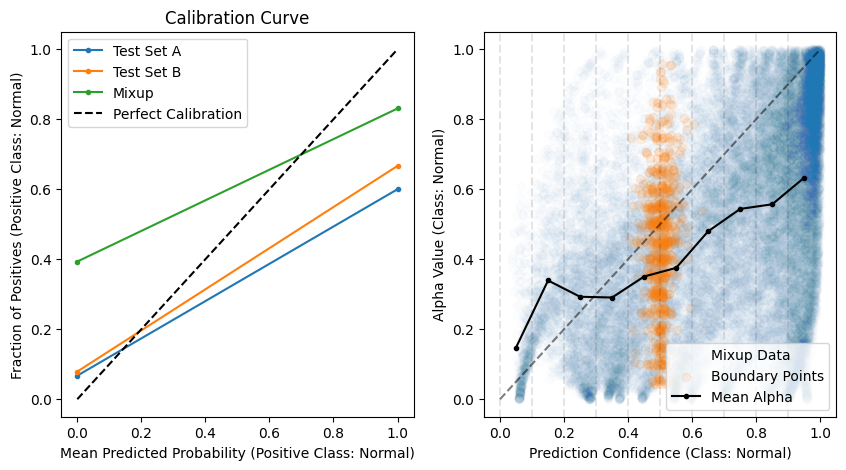

In [18]:
plot_calibration(true_images_A_df,true_images_B_df,mixup_images_df,boundary_images_df, positive_class = "Normal")